In [1]:
#import all da nice stuff
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D

import shutil

In [10]:
base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"
amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
LOV_gene = "TTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAA"
#ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa
LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
gene_len = len(LOV)*3
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right=5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = ['ATA', 'ATC', 'ATT', 'ATG',
  'ACA', 'ACC', 'ACG', 'ACT',
  'AAC', 'AAT', 'AAA', 'AAG',
  'AGC', 'AGT', 'AGA', 'AGG',
  'CTA', 'CTC', 'CTG', 'CTT',
  'CCA', 'CCC', 'CCG', 'CCT',
  'CAC', 'CAT', 'CAA', 'CAG',
  'CGA', 'CGC', 'CGG', 'CGT',
  'GTA', 'GTC', 'GTG', 'GTT',
  'GCA', 'GCC', 'GCG', 'GCT',
  'GAC', 'GAT', 'GAA', 'GAG',
  'GGA', 'GGC', 'GGG', 'GGT',
  'TCA', 'TCC', 'TCG', 'TCT',
  'TTC', 'TTT', 'TTA', 'TTG',
  'TAC', 'TAT', 'TAA', 'TAG',
  'TGC', 'TGT', 'TGA', 'TGG']


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

# Functions

In [3]:
def r(x, y):
    return stats.spearmanr(x, y)

def correlation_plot(data, combination):
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['axes.linewidth'] = 2
    g = sns.regplot(y=data[:,0], x=data[:,1], color='grey', ci=None, 
        scatter_kws={'alpha':.6, 'linewidth':0}, line_kws={"linewidth":0, 
        'label':f"Spearman's r: {round(r(data[~np.isnan(data).any(axis=1),:][:,0], data[~np.isnan(data).any(axis=1),:][:,1])[0], 2)}"})
    plt.xlabel('Log2 enrichment rep-1')
    plt.ylabe
    l('Log2 enrichment rep-2')
    plt.xlim(data[~np.isnan(data).any(axis=1),:].min().min()-.5, data[~np.isnan(data).any(axis=1),:].max().max() +.5)
    plt.ylim(data[~np.isnan(data).any(axis=1),:].min().min()-.5, data[~np.isnan(data).any(axis=1),:].max().max() +.5)
    sns.despine()
    g.tick_params(width=2)
    g.legend(frameon=False, loc='upper right')
    plt.title(f"{combination}", y=1.03)
    #plt.savefig(f"{fig_folder}/correlation_{combination}_{property}.svg")

def library_coverage(data, name):
    #process data
    AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
    data = data.loc[AA_order]
    mask = data.isnull()

    plt.figure(figsize=(5,5))
    ax = sns.heatmap(data=data, cmap='mako', cbar_kws={'label': f"Read counts"}, square=True, mask=mask)
    plt.title(name)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)
    #plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

map = sns.diverging_palette(10, 260, s=100, l=30, as_cmap=True)
def mutation_enrichment(data, name):
    #process data
    AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
    data = data.loc[AA_order]
    mask = data.isnull()

    #center colorbar
    vcenter = 0
    vmin, vmax = data.min().min(), data.max().max()
    normalize = mcolors.TwoSlopeNorm(vcenter=0.01, vmin=0, vmax=0.1)

    plt.figure(figsize=(24,4))
    ax = sns.heatmap(data=data, cmap='viridis', cbar_kws={'label': f"counts"}, square=True, norm=normalize, mask=mask)
    plt.title(name)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)
    #plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

def correlation_light_dark(dark, light, name, x_name='Light', y_name='Dark'):
    light_dark = pd.DataFrame(np.column_stack([dark.stack(dropna=False).to_list(),
                                    light.stack(dropna=False).to_list()]), columns=['Dark', 'Light'])
    stop_codons = pd.DataFrame(np.column_stack([dark.loc['*'].to_list(),
                                light.loc['*'].to_list()]), columns=['Dark', 'Light'])
    #light_dark = light_dark.iloc[1:-1,:]
    sns.set(font_scale = 1)
    sns.set_style("ticks", rc={'font.family':'sans-serif', 'font.sans-serif':'Droid Sans'})
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    ax = sns.scatterplot(data=light_dark, x='Light', y='Dark', color='grey', alpha=.4, linewidth=0, legend=False)
    ax1 = sns.scatterplot(data=stop_codons, x='Light', y='Dark', color='red', alpha=1, linewidth=0, legend=False)
    plt.xlabel(f"{x_name} log2 enriched read counts")
    plt.ylabel(f"{y_name} log2 enriched read counts")
    plt.xlim(light_dark.min().min()-1, light_dark.max().max() +1)
    plt.ylim(light_dark.min().min()-1, light_dark.max().max() +1)
    sns.despine()
    plt.axvline(0, 1,0, color='black', linewidth=2)
    plt.axhline(0, 1,0, color='black', linewidth=2)
    plt.title(f"{name} light vs dark")
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)



In [145]:
def find(string, value_list):
    indexes = [string.find(letter) for letter in value_list]
    try: 
        ind = min([index for index in indexes if index != -1])
    except:
        ind = 400 #250
    return ind

def read_sequences(variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False):
    """
    read sequences from fastq files while filtering for quality score (read is aborted at first nt with higher error rate than 1%)
    arbitrary_cutoff_a: at which position to arbitrary cut off the forward reads that already went through the quality score filter (= max length of the reads)
    arbitrary_cutoff_b: at which position to arbitrary cut off the backward reads that already went through the quality score filter (= max length of the reads)
    returns list of sequences
    """
    sequences = []
    a_sequences = []
    b_sequences = []
    y=0
    quality_score = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
    with open(f'{base_dir}/data/fastq/{variant}_R1_001.fastq', "rt") as a_file, open(f'{base_dir}/data/fastq/{variant}_R2_001.fastq', "rt") as b_file:
        a_reader = QualityIO.FastqGeneralIterator(a_file)
        b_reader = QualityIO.FastqGeneralIterator(b_file)
        for total_read, (a, b) in enumerate(zip(a_reader, b_reader)):
                #if y < 10000:
                a_id, a_seq, a_qual = a
                b_id, b_seq, b_qual = b
                cutoff_a = find(a_qual, quality_score)
                cutoff_b = find(b_qual, quality_score)

                if arbitrary_cutoff_a and catch_left in a_seq: # cut off a_seq to maximum length (=arbitrary_cutoff_a)
                    if cutoff_a > (a_seq.index(catch_left) + arbitrary_cutoff_a):
                        cutoff_a = a_seq.index(catch_left)  + len(catch_left) + arbitrary_cutoff_a 
                
                if arbitrary_cutoff_b and dna_rev_comp(catch_right) in b_seq: 
                    if cutoff_b > (b_seq.index(dna_rev_comp(catch_right)) + arbitrary_cutoff_b):
                        cutoff_b =b_seq.index(dna_rev_comp(catch_right))+ len(catch_right) + arbitrary_cutoff_b
                    
                a_sequences.append(a_seq[:cutoff_a])
                b_sequences.append(b_seq[:cutoff_b])
                
                y+=1
                #else: 
                #    break
        print("total reads", total_read+1)
    return a_sequences, b_sequences

def gather_AA_variants(a_seq, b_seq,use_backward_read=True, use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
    """
    returns a dictionary with the counts of each amino acid at each position
    """
    mutation_dict = {}
    undefined = 0
    counter = 0
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    stops = 0
    
    for idx in range(len(LOV)):
        mutation_dict[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
                                                'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
                                                'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
                                                'W':0, 'Y':0, '*':0, 'wt':0}
    for a_seq, b_seq in zip(a_seq, b_seq):
        counter +=1
        if counter%100000 == 0:
            print(counter)
        if use_forward_read:
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                tr_a = translate_dna2aa(gene_a)
                for idx, pos in enumerate(tr_a):
                    mutation_dict[idx][pos] += 1
        if use_backward_read: 
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                tr_b = translate_dna2aa(gene_b)
                tr_b = tr_b[::-1]
                for idx, pos in enumerate(tr_b):
                    mutation_dict[len(LOV)-idx-1][pos] += 1

    return mutation_dict

def gather_codon_variants(a_seq, b_seq , use_backward_read= True,use_forward_read = True, catch_left = catch_left, catch_right = catch_right, codons = codons):
    """
    returns a dictionary with the counts of each codon at each position
    """
    mutation_dict = {}
    undefined = 0
    counter = 0
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    stops = 0
    
    for idx in range(0, gene_len//3):
        mutation_dict[idx] = {codon: 0 for codon in codons}

    for a_seq, b_seq in zip(a_seq, b_seq):
        #counter +=1
        #if counter%100000 == 0:
        #    print(counter)
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                #tr_a = translate_dna2aa(gene_a)
                for idx in range(len(gene_a)//3): # tripletwise
                    mutation_dict[idx][gene_a[idx*3:idx*3+3]] += 1
        # if use_backward_read:
        #     if dna_rev_comp(catch_right) in b_seq:
        #         index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
        #         gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
        #         #tr_b = translate_dna2aa(gene_b)
        #         gene_b = gene_b[::-1]
        #         for idx, pos in enumerate(gene_b):
        #             mutation_dict[gene_len-idx-1][pos] += 1

    return mutation_dict



def gather_nt_variants(a_seq, b_seq , use_backward_read= True,use_forward_read = True, catch_left = catch_left, catch_right = catch_right):
    """
    returns a dictionary with the counts of each nt at each position
    """
    mutation_dict = {}
    undefined = 0
    counter = 0
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    stops = 0
    
    for idx in range(gene_len):
        mutation_dict[idx] = {'A':0, 'T':0, 'G':0, 'C':0}

    for a_seq, b_seq in zip(a_seq, b_seq):
        #counter +=1
        #if counter%100000 == 0:
        #    print(counter)
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                #tr_a = translate_dna2aa(gene_a)
                for idx, pos in enumerate(gene_a):
                    mutation_dict[idx][pos] += 1
        if use_backward_read:
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                #tr_b = translate_dna2aa(gene_b)
                gene_b = gene_b[::-1]
                for idx, pos in enumerate(gene_b):
                    mutation_dict[gene_len-idx-1][pos] += 1

    return mutation_dict


def process_reads(AA_sequence,DNA,use_backward_read = True, use_forward_read = True, arbitrary_cutoff_a = False, arbitrary_cutoff_b= False, variants = None):
    """
    process reads for given variants
    use_backward_read: whether or not to use the backward read
    arbitrary_cutoff: where to cut off the forward sequence (maximum length of the reads, otherwise the cutoff is determined by the quality score = 1% error rate)
    if variants = None, all variants stored in the fastq folder are processed
    """
    variants_dict = {}
    path = f'{base_dir}/data/fastq'
    filenames = glob.glob(f'{path}/*')

    if variants is not None: # filter filenames for given variants
        filenames = [path for path in filenames if any(variant in path for variant in variants)]

    for name in filenames: 
        if '_R1' in name:
            name = name.split('/')[-1].split('_R')[0]
            peptide_length = len(AA_sequence)
            length = len(AA_sequence) * 3
            flank_len = 10
            #process sequences
            sequences = []
            results = []
            f1 = name
            a_seq, b_seq = read_sequences(f1, arbitrary_cutoff_a = arbitrary_cutoff_a, arbitrary_cutoff_b=arbitrary_cutoff_b)
            variants_dict[name] = {}
            variants_dict[name]["AA"] = gather_AA_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
            variants_dict[name]["DNA"] = gather_nt_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
            variants_dict[name]["Codons"] = gather_codon_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
            print(f'Done: {name}')

        # with open(f'{path}/{variant}_variants.pickle', 'wb') as handle:
        #     pkl.dump(variants_dict, handle)
    return variants_dict

def get_variants(a_seq,b_seq,use_backward_read=True,use_forward_read=True):
    
    variants_dict = {}
    variants_dict["AA"] = gather_AA_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
    variants_dict["DNA"] = gather_nt_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)
    variants_dict["Codons"] = gather_codon_variants(a_seq, b_seq, use_backward_read=use_backward_read, use_forward_read=use_forward_read)

    return variants_dict


In [187]:
## evaluation 

### calculate sum of single, double and triple mutants
def gather_n_mutations(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True, use_triplets = False):
    """
    returns a dictionary with the number of single, double, triple (...) mutants
    a_seq, b_seq = list of sequences
    """
    mutation_dict = {}
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if use_forward_read and catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            if use_triplets: 
                 n_muts_a_seq = sum([reference_seq[i:i+3] != gene_a[i:i+3] for i in range(0,len(gene_a)//3*3,3)])
                # for i in range(0,len(gene_a)//3*3,3):
                #     print(i, i+3, len(gene_a), reference_seq[i:i+3], gene_a[i:i+3], reference_seq[i:i+3] != gene_a[i:i+3])
            else: 
                n_muts_a_seq = sum([reference_seq[i] != gene_a[i] for i in range(len(gene_a))])
            #print("new read")
            #print("sum", n_muts_a_seq)
        else: n_muts_a_seq = 0
            
        if use_backward_read and dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                n_muts_b_seq = sum([reference_seq[::-1][i] != gene_b[i] for i in range(len(gene_b))])
                #print("sum", n_muts_b_seq)
        else: n_muts_b_seq = 0

        n_muts = n_muts_a_seq + n_muts_b_seq
        
        if n_muts in mutation_dict:
            mutation_dict[n_muts] += 1
        else:
            mutation_dict[n_muts] = 1

    return mutation_dict


### calculate the mutagenic spectrum
def mut_spectrum(a_seq, b_seq, reference_seq, use_backward_read = True, use_forward_read = True):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference nt: {mutated nt: count/percentage}}
    """
    ## reference nt : {mutated nt: count}
    mut_spec = {'A': {'A':0, 'C':0, 'G':0, 'T':0},
                'C': {'A':0, 'C':0, 'G':0, 'T':0},
                'G': {'A':0, 'C':0, 'G':0, 'T':0},
                'T': {'A':0, 'C':0, 'G':0, 'T':0}}
    
    catch_length = len(catch_left)
    
    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                for idx, nt in enumerate(gene_a): 
                    if reference_seq[idx] != nt:
                        mut_spec[reference_seq[idx]][nt] += 1
            
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                for idx, nt in enumerate(gene_b):
                    if reference_seq[::-1][idx] != nt:
                        mut_spec[reference_seq[::-1][idx]][nt] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc

### calculate the mutagenic spectrum codon-wise
def mut_spectrum_codons(a_seq, b_seq, reference_seq, use_backward_read = False, use_forward_read = True, codon_list = codons):
    """
    input: 
    a_seq, b_seq = list of sequences
    reference_seq = reference sequence
    
    returns two dictionaries: (1) with the total counts of the mutagenic spectrum of codons and (2) dict with percentage of the mutagenic spectrum
    with the following structure: {reference codon: {mutated codon: count/percentage}}
    """
    ## reference codon : {mutated codon: count}
    mut_spec = {ref_codon: {codon:0 for codon in codon_list} for ref_codon in codon_list}
    print(mut_spec)
    catch_length = len(catch_left)
    
    for a_seq, b_seq in zip(a_seq, b_seq):
                
        if use_forward_read: 
            if catch_left in a_seq:
                index = a_seq.index(catch_left) + catch_length
                gene_a = a_seq[index:]
                ## if number of total muts does not exceed 5, this is a mutation and not indel, thus it is used for the mutagenic spectrum
                total_muts_a = sum([reference_seq[idx] != gene_a[idx] for idx in range(len(gene_a))])
                if total_muts_a <= 4:
                    for idx in range(0,len(gene_a)//3*3,3): 
                        if reference_seq[idx:idx+3] != gene_a[idx:idx+3]:
                            mut_spec[reference_seq[idx:idx+3]][gene_a[idx:idx+3]] += 1
                
        if use_backward_read:        
            if dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                total_muts_b = sum([reference_seq[::-1][idx] != gene_b[idx] for idx in range(len(gene_b))])
                if total_muts_b <= 4:
                    for idx in range(0,len(gene_b)//3*3,3):
                        if reference_seq[::-1][idx:idx+3] != gene_b[idx:idx+3]:
                            mut_spec[reference_seq[::-1][idx:idx+3]][gene_b[idx:idx+3]] += 1
    
    ## calculate mutagenic spectrum in percentage
    total_n_muts = sum([sum(value.values()) for value in mut_spec.values()])
    mut_spec_perc = {ref_base: {mut_base: round(val/total_n_muts*100, 3) for mut_base, val in value.items()} for ref_base, value in mut_spec.items()}

    return mut_spec, mut_spec_perc


def plot_mutation_spectrum(data, samplename , fig_folder = None):
    """
    plot mutation spectrum (%) as heatmap
    data = dataframe with the mutagenic spectrum (rows = reference nt, columns = mutated nt)
    savepath = folder path to save the figure
    """
    f, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(data, annot=True, linewidths=.5, ax=ax, vmin = 0, cbar = False, square = True, linecolor = "black", cmap = "viridis")
    plt.xlabel('Mutated base (%)', fontsize = 10)
    plt.ylabel('Reference base (%)', fontsize = 10)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(.5)
    #ax.set_facecolor('gray')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    plt.title(f"{samplename} mutagenic spectrum", fontsize = 12)
    if fig_folder is not None:
        plt.savefig(f"{fig_folder}/{samplename}_mutagenic_spectrum_perc.pdf")
    plt.show()


def plot_mutation_enrichment(data, name, ref_seq, backward = False, data_type = "DNA", fig_folder = None):
    """
    data_type = "DNA", "AA" or "Codon" 
    reference nucleotides/AAs/Codons are shown in grey (set to NA)
    backward: if True, only backward reads are used
    input data should be a dataframe with the relative counts of each nucleotide/AA/Codon at each position
    name = plot title
    """
    #process data
    if data_type == "DNA":
        Nt_order = ['A','C', 'G', 'T']
        data = data.loc[Nt_order]
    elif data_type == "AA": 
        AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
        data = data.loc[AA_order]
    

    #mask = data.isnull()
    # set max value = original Nt (AA) of each column to NA (as "true" nt)
    #data = data.mask(data == data.max())
    
    ## mask at each position the nucleotide of the reference sequence
    read_len = data.shape[1]
    
    if data_type in ["DNA", "AA"]:
        if backward: 
            ref_seq = ref_seq[::-1]
            for idx in range(read_len):
                data.loc[ref_seq[idx], len(ref_seq)-idx-1] = np.nan
        else: 
            for idx in range(read_len):
                data.loc[ref_seq[idx], idx] = np.nan

    elif data_type == "Codons":
        if backward: 
            ref_seq = ref_seq[::-1]
            for idx in range(0,read_len//3*3,3):
                data.loc[ref_seq[idx:idx+3], len(ref_seq//3)-idx-1] = np.nan
        else: 
            for idx in range(read_len):
                data.loc[ref_seq[idx*3:idx*3+3], idx] = np.nan
        

    #center colorbar
    #vcenter = 0
    #vmin, vmax = data.min().min(), data.max().max()
    #normalize = mcolors.TwoSlopeNorm(vcenter=0.02, vmin=0, vmax=0.04)

    plt.figure(figsize=(30,10))
    sns.reset_defaults()
    
    #sns.set(font_scale =5)
    ax = sns.heatmap(data=data, cmap='viridis', cbar_kws={'label': f"relative counts"}, yticklabels=True)#, mask=mask)
    plt.title(name, fontsize=20)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=10)
    ax.xaxis.set_tick_params(width=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=1, fontsize=10)
    ax.yaxis.set_tick_params(width=2)
    ax.set_facecolor('gray')
    ax.grid(False)
    if fig_folder is not None:    
        plt.savefig(f"{fig_folder}/{name}_mutation_enrichement.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

def mutation_rate_vs_read_depth(a_seq, b_seq, percs , name, n_perms = 30, fig_folder = None, use_backward_read = False):
    total_reads = len(a_seq)
    coverages_dict = {}
    mut_rates_AA_dict = {}
    mut_rates_DNA_dict = {}

    for perc in percs:  
        perc= round(perc,2) 
        coverages = []
        mut_rate_AAs = []
        mut_rate_DNAs = []
        for n_perm in range(n_perms): 
            a_seq_frac = np.random.choice(a_seq, round(perc * total_reads), replace=False)
            b_seq_frac = np.random.choice(b_seq, round(perc * total_reads), replace=False)
            frac_variants = get_variants(a_seq_frac, b_seq = b_seq_frac, use_backward_read = use_backward_read, use_forward_read = True)
            frac_variants["DNA"] = pd.DataFrame.from_dict(frac_variants["DNA"])
            frac_variants["DNA"] = frac_variants["DNA"].loc[:,frac_variants["DNA"].sum() > 0]
            frac_variants["AA"] = pd.DataFrame.from_dict(frac_variants["AA"])
            frac_variants["AA"] = frac_variants["AA"].loc[:,frac_variants["AA"].sum() > 0]
            
            coverage = frac_variants['DNA'].sum().sum()/(frac_variants['DNA'].max().max()*frac_variants['DNA'].shape[1])*100

            mut_rate_AA = frac_variants['AA'].max()/frac_variants['AA'].sum()-1
            mut_rate_AA = abs(mut_rate_AA.sum())

            mut_rate_DNA = frac_variants['DNA'].max()/frac_variants['DNA'].sum()-1
            mut_rate_DNA = abs(mut_rate_DNA.sum()) #round(mut_rate/coverage*100,2)

            coverages.append(coverage)
            print(coverage)
            mut_rate_AAs.append(round(mut_rate_AA/coverage*100,2))
            mut_rate_DNAs.append(round(mut_rate_DNA/coverage*100,2))

        coverages_dict[perc] = coverages
        mut_rates_AA_dict[perc] = mut_rate_AAs
        mut_rates_DNA_dict[perc] = mut_rate_DNAs

    ## plot

    plt.figure(figsize=(10,5))
    sns.stripplot(data=mut_rates_DNA_dict,  alpha=0.5, color="tab:blue")
    sns.stripplot(data=mut_rates_AA_dict,  alpha=0.5, color="tab:orange")
    plt.ylim(0)

    blue_patch = Line2D([0], [0], label='DNA', marker='o', markersize=5,linestyle='', color = "tab:blue", alpha = 0.7)
    orange_patch = Line2D([0], [0], label='AA', marker='o', markersize=5, linestyle='', color = "tab:orange", alpha = 0.7)
    plt.legend(handles =[orange_patch, blue_patch],  loc = "upper right", frameon = False)
    plt.xlabel("Read depth (proportion of total reads)")
    plt.ylabel("Mutation rate (# mutations per sequence)")
    plt.title(name)
    if fig_folder: 
        plt.savefig(f"{fig_folder}/{name}_mutation_rate_vs_read_depth.pdf")
    plt.show()

    return coverages_dict, mut_rates_AA_dict, mut_rates_DNA_dict

            
def calc_mut_spectrum_vs_read_depth(a_seq,b_seq, reference_seq, use_backward_read = False, use_forward_read= True, prop = 0.5, n_perms = 30): 
    mut_spec_diff_sum = pd.DataFrame(0, index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"]) 
    mean_diffs = []

    ## calculate "reference" mutagenic spectrum
    _, mut_spec_perc_ref = mut_spectrum(a_seq=a_seq, b_seq=b_seq, reference_seq=reference_seq, use_backward_read = use_backward_read, use_forward_read = use_forward_read)
    mut_spec_perc_ref = pd.DataFrame.from_dict(mut_spec_perc_ref)

    for n_perm in range(n_perms):
    
        a_seq_frac = np.random.choice(a_seq, round(prop * len(a_seq)), replace=False)
        b_seq_frac = np.random.choice(b_seq, round(prop * len(b_seq)), replace=False)
        _, mut_spec_perc_frac = mut_spectrum(a_seq = a_seq_frac, b_seq = b_seq_frac, reference_seq=reference_seq, use_backward_read = use_backward_read, use_forward_read = use_forward_read)
        mut_spec_perc_frac = pd.DataFrame.from_dict(mut_spec_perc_frac)

        # calculate difference between the two mutagenic spectra
        mut_spec_diff = (mut_spec_perc_frac - mut_spec_perc_ref)**2
        mean_diff = mut_spec_diff.mean().mean()
        mean_diffs.append(mean_diff)

        # calculate the sum of the squared differences over all permutations
        mut_spec_diff_sum = mut_spec_diff_sum + mut_spec_diff

    # calculate the average of the squared differences per nt conversion
    mut_spec_diff_mse = mut_spec_diff_sum/n_perms

    return mut_spec_diff_mse, mean_diffs


# AraC analysis

In [178]:
variant = "DP6"
name = "DP6-R1"
FigFolder = f"{base_dir}/figures/"


seq_variants = process_reads(amplicon, amplicon_DNA, variants = [variant], use_backward_read=False, use_forward_read=True)#arbitrary_cutoff_b = 21)#, arbitrary_cutoff_a=160, use_backward_read = False)
seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants[variant]["DNA"])
seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants[variant]["AA"])
seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]

seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants[variant]["Codons"])
seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

total reads 59259
Done: DP6


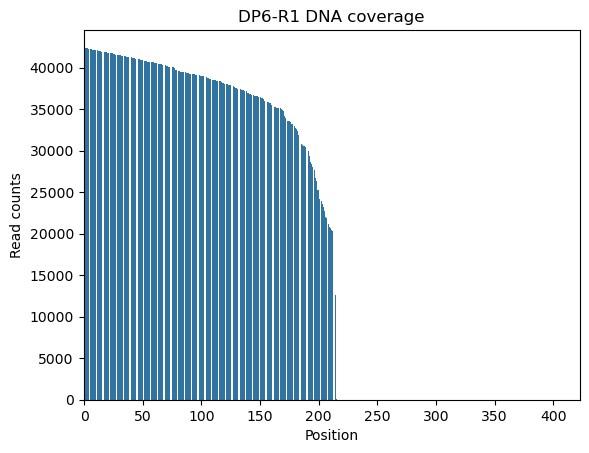

In [445]:
#ax = sns.barplot(DP6_variants["AA"].sum())
#plt.xticks(list(range(0,len(LOV),20)))
#plt.title("AA coverage")
#plt.show()
#plt.clf

ax = sns.barplot(seq_variants["DNA"].sum())
#plt.xlim(400)

plt.xticks(list(range(0,gene_len, 50)))
plt.xlabel("Position")
plt.ylabel("Read counts")
plt.title(f'{name} DNA coverage')
plt.savefig(f'figures/{name}_DNA_coverage.pdf')
plt.show()


### NOTE that the quality score cutoff is set to a 1 % error rate

In [432]:
coverage = seq_variants['DNA'].sum().sum()/(seq_variants['DNA'].max().max()*seq_variants['DNA'].shape[1])*100
print(f'The illumina paired reads cover on average {coverage.round(1)} % of the LOV sequence')

mut_rate = seq_variants['AA'].max()/seq_variants['AA'].sum()-1
mut_rate = abs(mut_rate.sum())
print(f'The mutation rate is estimated to be {mut_rate.round(1)} AA mutations per sequence')
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate/coverage*100,2)} AA mutations per sequence')

mut_rate = seq_variants['DNA'].max()/seq_variants['DNA'].sum()-1
mut_rate = abs(mut_rate.sum())  # this is the mutation rate per nucleotide, based on the number of reads (per nt)
print(f'The mutation rate is estimated to be {mut_rate.round(1)} DNA mutations per sequence') 
print(f'If we correct for the coverage, we expect a mutation rate of {round(mut_rate/coverage*100,2)} DNA mutations per sequence')

The illumina paired reads cover on average 93.2 % of the LOV sequence
The mutation rate is estimated to be 0.1 AA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.09 AA mutations per sequence
The mutation rate is estimated to be 0.2 DNA mutations per sequence
If we correct for the coverage, we expect a mutation rate of 0.18 DNA mutations per sequence


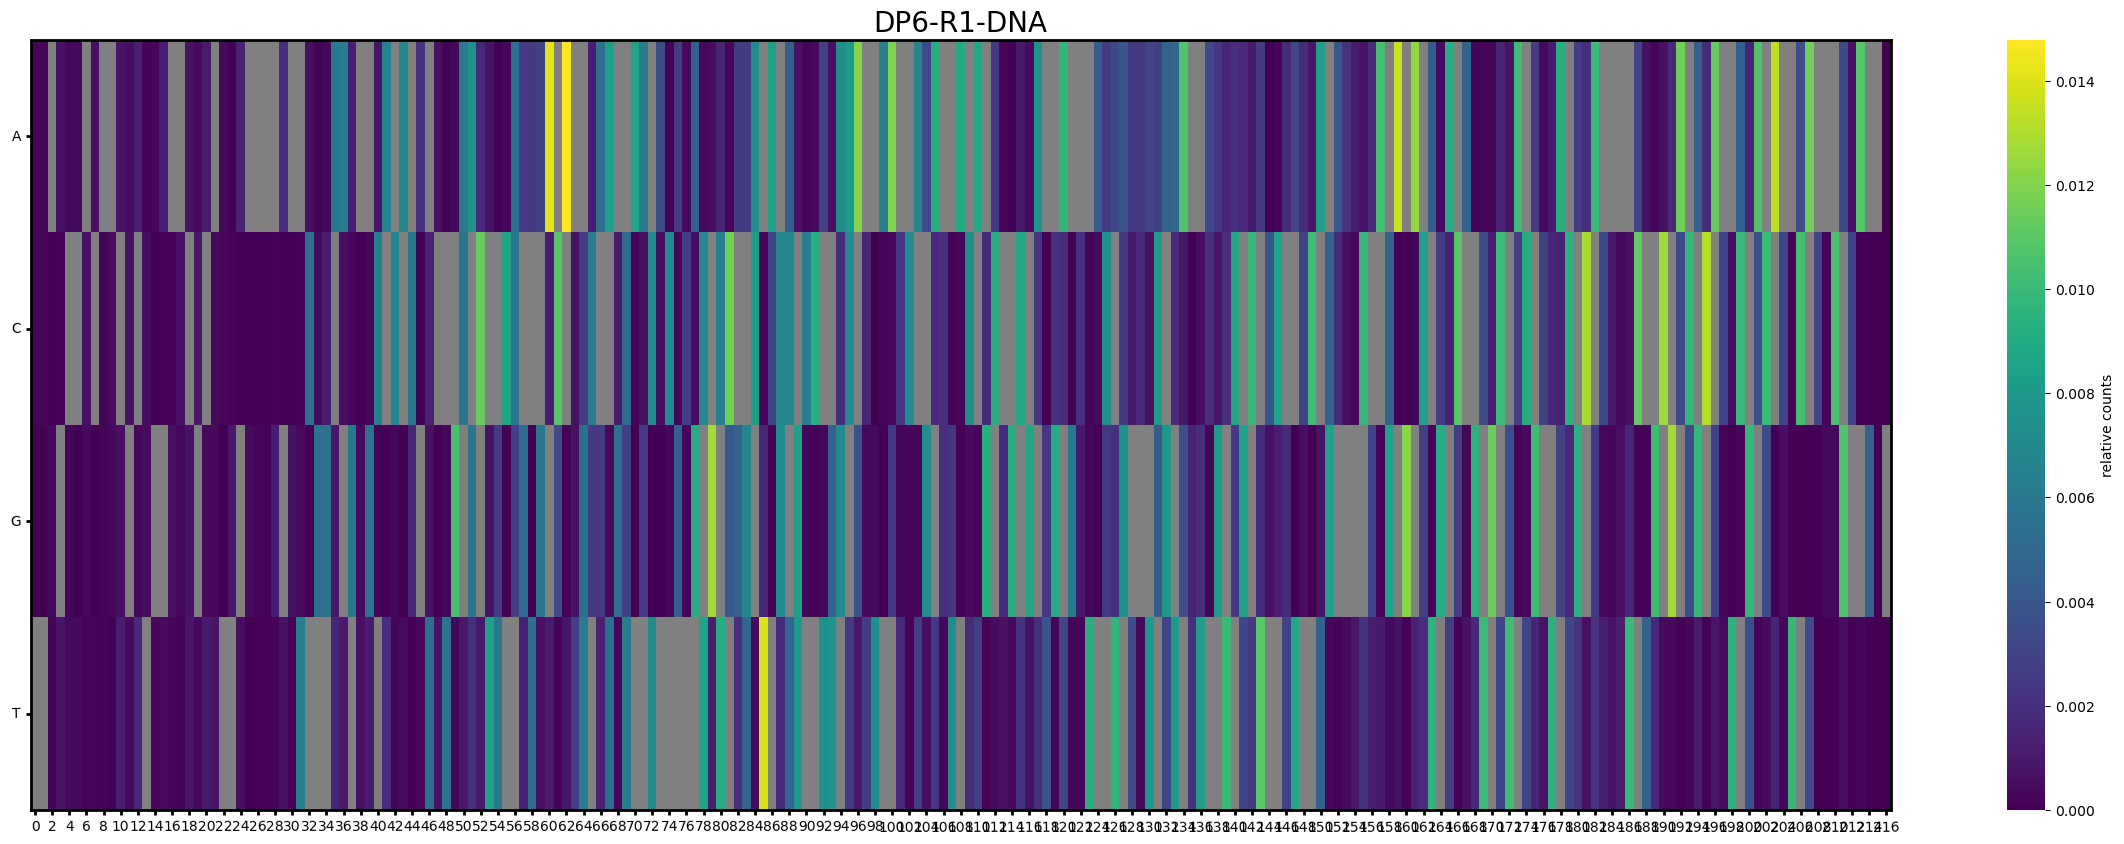

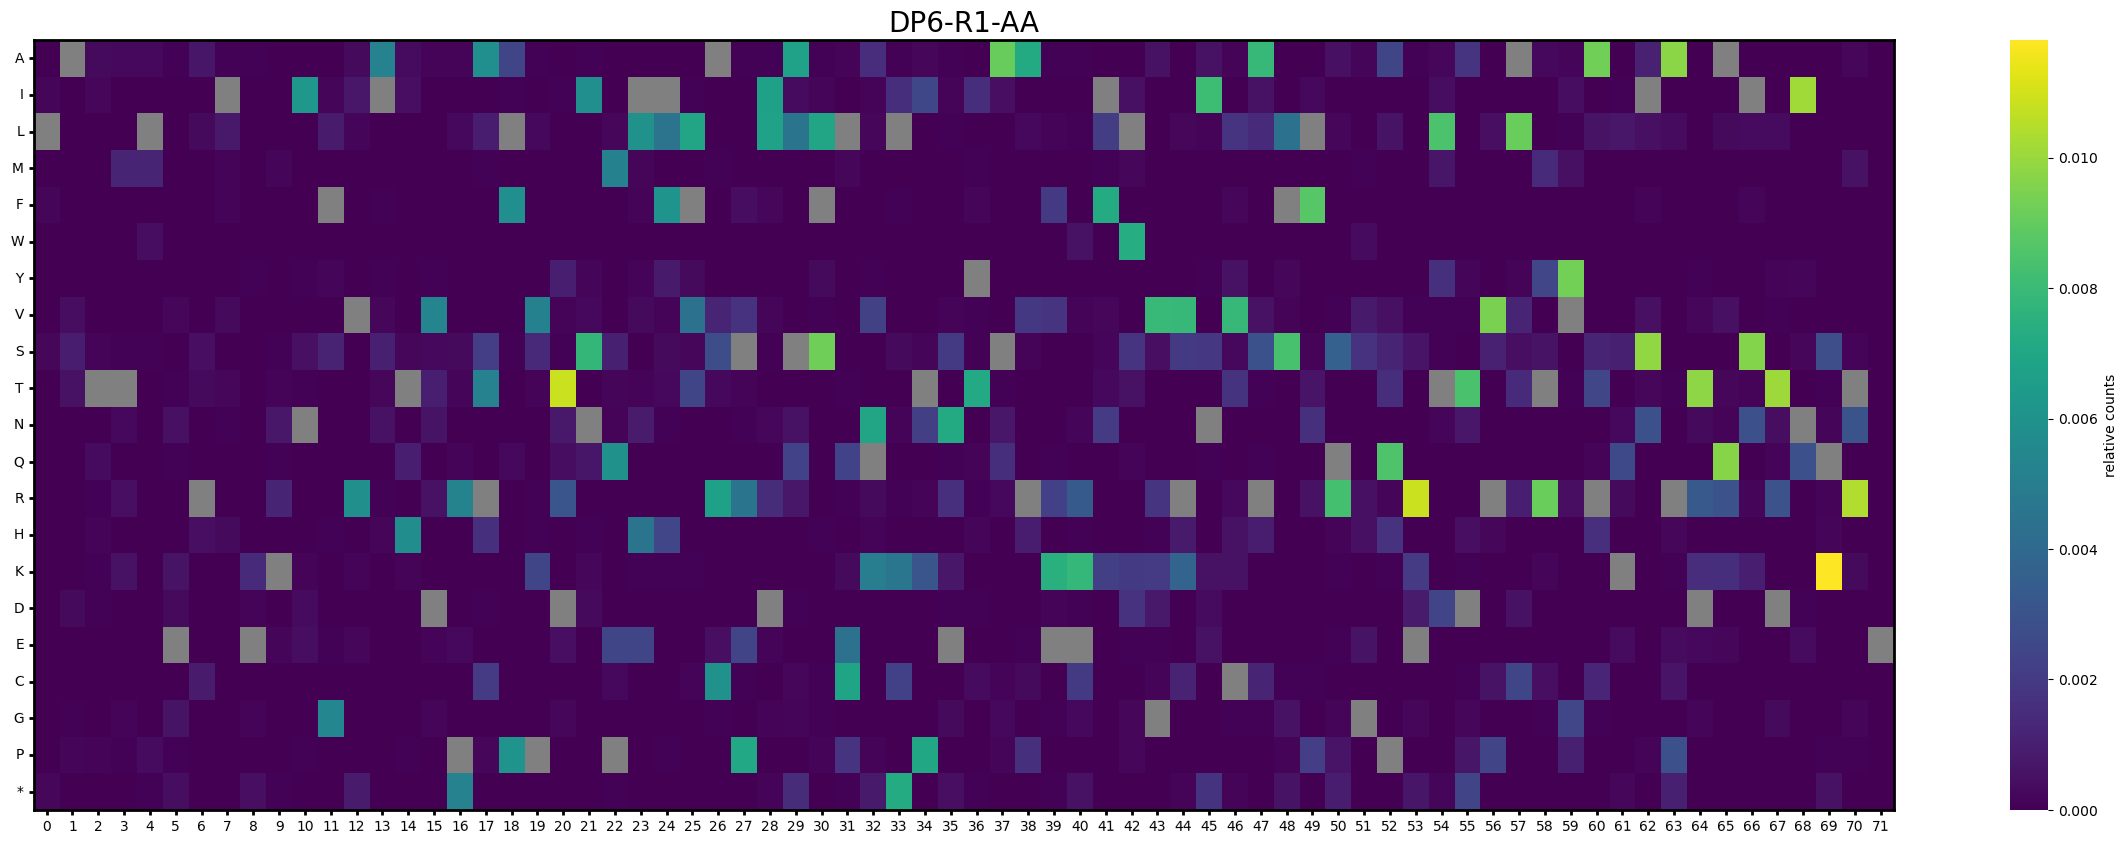

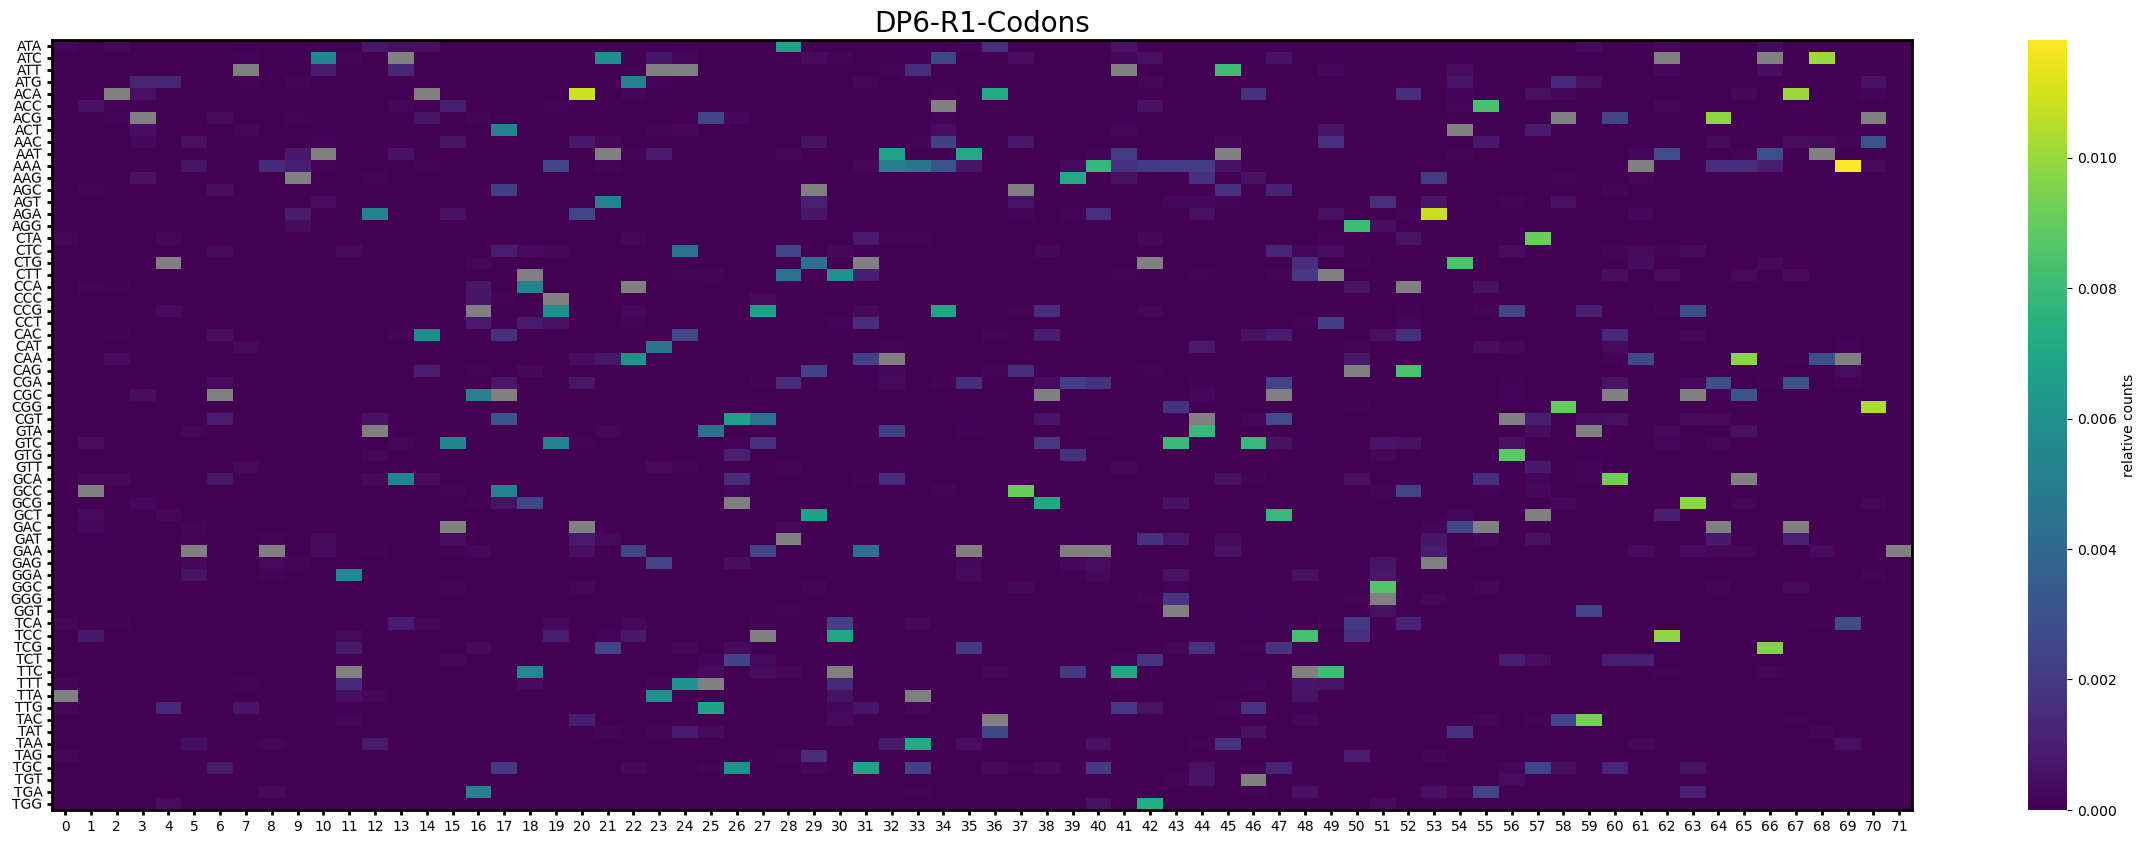

In [188]:
DNA_relative = seq_variants['DNA']/seq_variants['DNA'].sum()
DNA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(DNA_relative, name =  f'{name}-DNA', backward=False, data_type = "DNA", ref_seq=LOV_gene, fig_folder=None)

AA_relative = seq_variants['AA']/seq_variants['AA'].sum()
AA_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(AA_relative, f'{name}-AA',ref_seq=LOV,data_type = "AA", backward = False, fig_folder=None)


Codons_relative = seq_variants['Codons']/seq_variants['Codons'].sum()
Codons_relative.dropna(axis = 1, inplace=True)
plot_mutation_enrichment(Codons_relative, f'{name}-Codons',ref_seq=LOV_gene,data_type = "Codons", backward = False, fig_folder=None)


In [708]:
a_seq, b_seq = read_sequences("DP6")
DP6_n_muts = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_triplets=True)

total reads 59259


In [96]:
a_seq, b_seq = read_sequences(variant)
seq_n_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_triplets=True)
## sort dictionary after key
seq_n_mutations = dict(sorted(seq_n_mutations.items()))

print(seq_n_mutations)

total reads 47233
{0: 38227, 1: 6329, 2: 880, 3: 93, 4: 25, 5: 10, 6: 16, 7: 10, 8: 20, 9: 24, 10: 29, 11: 17, 12: 18, 13: 20, 14: 12, 15: 21, 16: 23, 17: 28, 18: 33, 19: 36, 20: 36, 21: 31, 22: 25, 23: 24, 24: 44, 25: 30, 26: 41, 27: 26, 28: 40, 29: 36, 30: 32, 31: 29, 32: 29, 33: 33, 34: 31, 35: 37, 36: 33, 37: 23, 38: 28, 39: 35, 40: 25, 41: 27, 42: 34, 43: 22, 44: 28, 45: 28, 46: 23, 47: 31, 48: 36, 49: 16, 50: 24, 51: 37, 52: 28, 53: 21, 54: 37, 55: 26, 56: 32, 57: 28, 58: 22, 59: 16, 60: 32, 61: 31, 62: 27, 63: 13, 64: 22, 65: 12, 66: 12, 67: 5, 68: 7, 69: 10, 70: 7}


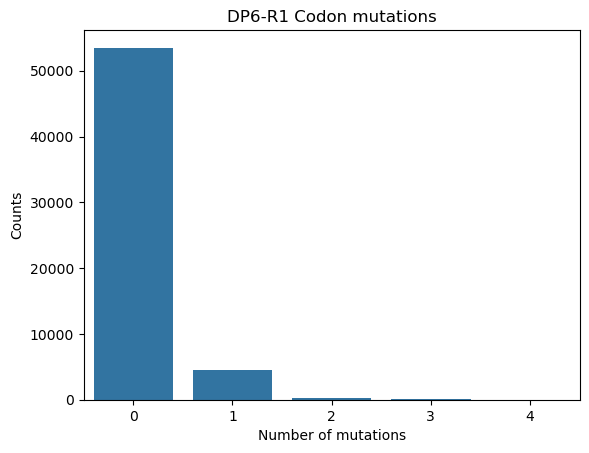

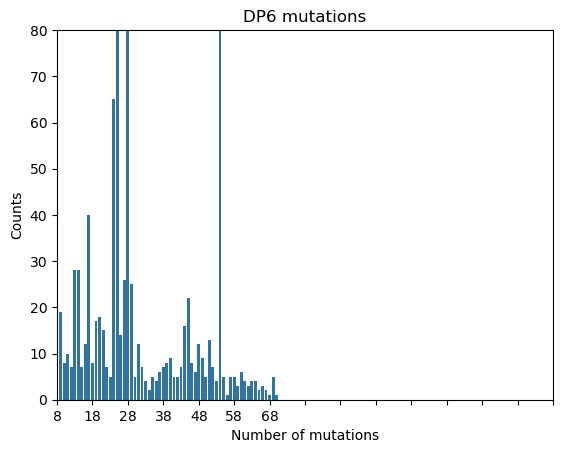

In [696]:
## plot number of mutations
sns.barplot(seq_n_mutations)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Counts')
plt.title(f'{variant}-R1 Codon mutations')
plt.savefig(f'figures/{variant}_R1_n_Codon_mutations_per_read.pdf')
plt.show()

plt.clf()
sns.barplot(seq_n_mutations)
plt.xlim(8.5)
plt.xticks(list(range(8, 150, 10)))
plt.ylim(0,80)
plt.xlabel('Number of mutations')
plt.ylabel('Counts')
plt.title(f'{variant} mutations')
plt.show()

{0: 0.8093282239112485, 1: 0.13399529989625897, 2: 0.018631041856329262, 3: 0.0019689623779984332, 4: 0.0005292909618275359, 5: 0.00021171638473101433, 6: 0.00033874621556962293, 7: 0.00021171638473101433, 8: 0.00042343276946202866, 9: 0.0005081193233544344, 10: 0.0006139775157199416, 11: 0.00035991785404272436, 12: 0.0003810894925158258, 13: 0.00042343276946202866, 14: 0.0002540596616772172, 15: 0.0004446044079351301, 16: 0.00048694768488133296, 17: 0.0005928058772468401, 18: 0.0006986640696123473, 19: 0.0007621789850316516, 20: 0.0007621789850316516, 21: 0.0006563207926661445, 22: 0.0005292909618275359, 23: 0.0005081193233544344, 24: 0.000931552092816463, 25: 0.000635149154193043, 26: 0.0008680371773971588, 27: 0.0005504626003006373, 28: 0.0008468655389240573, 29: 0.0007621789850316516, 30: 0.0006774924311392459, 31: 0.0006139775157199416, 32: 0.0006139775157199416, 33: 0.0006986640696123473, 34: 0.0006563207926661445, 35: 0.0007833506235047531, 36: 0.0006986640696123473, 37: 0.00048

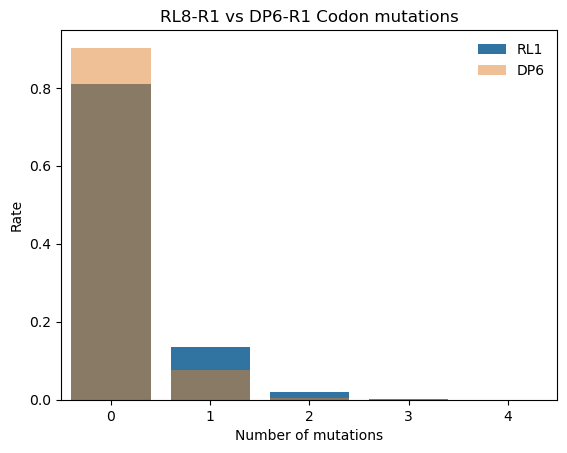

In [716]:
# rates of single, double, triple, ... mutations
total_reads = sum(seq_n_mutations.values())
n_mutation_rates = {key: value/total_reads for key, value in seq_n_mutations.items()}
print(n_mutation_rates)

total_reads = sum(DP6_n_muts.values())
DP6_n_mutation_rates = {key: value/total_reads for key, value in DP6_n_muts.items()}
print(DP6_n_mutation_rates)

sns.barplot(n_mutation_rates, label = "RL1")
sns.barplot(DP6_n_mutation_rates, alpha = 0.5, label = "DP6")
plt.legend(frameon = False)
plt.xlim(-0.5,4.5)
plt.xlabel('Number of mutations')
plt.ylabel('Rate')
plt.title(f'{variant}-R1 vs DP6-R1 Codon mutations') 
plt.savefig(f'figures/{variant}-R1_vs_DP6-R1_n_Codon_mutation_per_read_rates.pdf')
plt.show()

In [398]:
# calculate the mutation rate (!! different to before, here, we calculate the mutation rate per read, not per nt (i.e. we divide by the number of total reads, not the reads for each nt respectively!! --> perhaps inaccurate due to low coverage of some nts)
total_reads = sum(seq_n_mutations.values())
total_mutations = sum([key*value for key, value in seq_n_mutations.items()])
mutation_rate = total_mutations/total_reads
print(mutation_rate)

0.8281104979834287


In [399]:
a_seq, b_seq = read_sequences(variant, arbitrary_cutoff_a=150)
n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_forward_read=True )

print(n_mut_spectrum)
print(n_mut_spectrum_perc)

total reads 59259
{'A': {'A': 0, 'C': 3164, 'G': 3059, 'T': 3897}, 'C': {'A': 5131, 'C': 0, 'G': 4989, 'T': 4907}, 'G': {'A': 4044, 'C': 3808, 'G': 0, 'T': 2927}, 'T': {'A': 4452, 'C': 5336, 'G': 3359, 'T': 0}}
{'A': {'A': 0.0, 'C': 6.448, 'G': 6.234, 'T': 7.941}, 'C': {'A': 10.456, 'C': 0.0, 'G': 10.166, 'T': 9.999}, 'G': {'A': 8.241, 'C': 7.76, 'G': 0.0, 'T': 5.965}, 'T': {'A': 9.072, 'C': 10.874, 'G': 6.845, 'T': 0.0}}


In [400]:
n_mut_spectrum_perc_df = pd.DataFrame.from_dict(n_mut_spectrum_perc, orient='index')
n_mut_spectrum_df = pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
np.fill_diagonal(n_mut_spectrum_perc_df.values, np.nan)
np.fill_diagonal(n_mut_spectrum_df.values, np.nan)

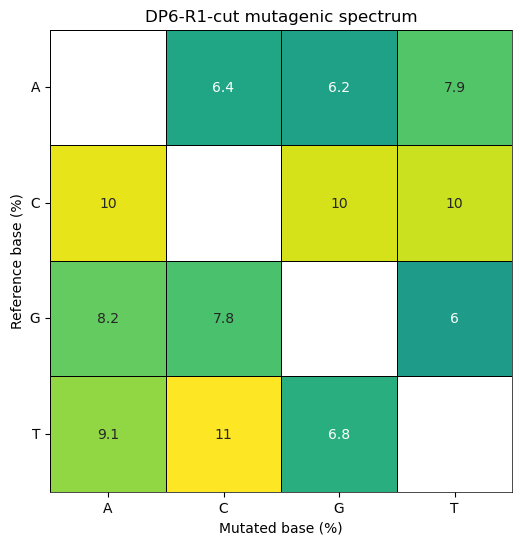

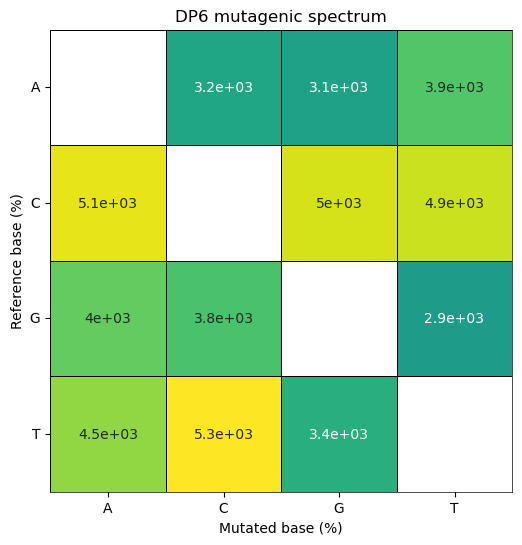

In [401]:
plot_mutation_spectrum(n_mut_spectrum_perc_df, f"{variant}-R1-cut", fig_folder = "figures")
#plot_mutation_spectrum(n_mut_spectrum_df, variant)


### Impact of read depth on mutation rate?

total reads 47233
88.04210743057163
87.89151406993587
88.5376322587095
88.47578855603106
89.37871318417393
86.94863616741772
88.74097531733
88.5067914121498
88.43646277856804
88.69140119140118
88.12680588389809
88.70633453966788
88.91413567623519
89.91769547325103
88.18617145526746
88.01557239057239
89.06885849688354
87.60720908669448
87.36311975995909
88.45080936665096
88.50607879347491
88.16072405973884
88.18433818433819
88.66066770996348
89.27883745573905
88.83837175294462
88.86734054223476
88.57304168279778
88.61331569664902
88.96363308332688
88.02771302771303
88.0929174788824
90.8560809944893
88.65819547670422
90.22524297346992
86.60680882903105
90.27308558558559
89.2378647586981
86.24567474048442
88.58915004748337
87.34254738061739
88.6518771331058
85.99819331526649
87.53812636165577
89.14837864395676
89.44011457500666
90.08554402153018
86.52723583580459
88.41960561243837
88.22073314938905
88.80885122410545
89.43032015065914
86.67589410716559
89.03314546430488
87.31350608559089
8

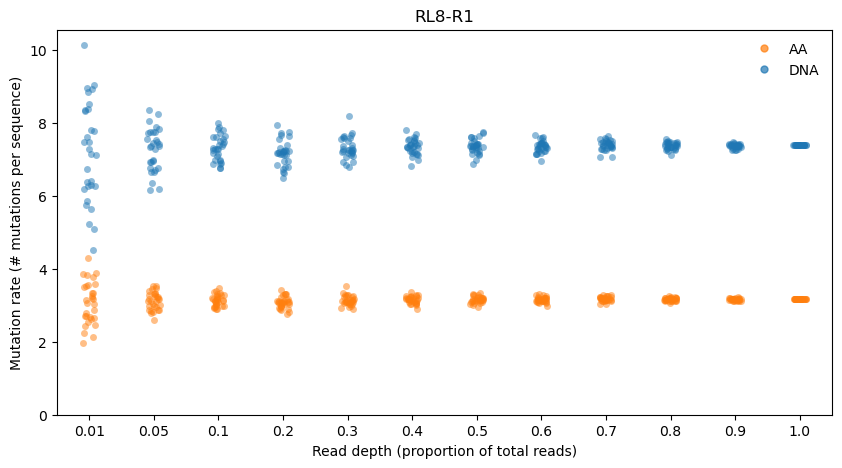

In [9]:
### randomly sample down the reads --> impact on mutation rate?
variant = "RL8"
name = "RL8-R1"
FigFolder = f"{base_dir}/figures/impact_of_read_depth/{name}"

a_seq, b_seq = read_sequences(variant)
percs = [0.05, 0.01] + [x * 0.1 for x in range(1, 11)]

coverages_dict, mut_rates_AA_dict, mut_rates_DNA_dict =  mutation_rate_vs_read_depth(a_seq=a_seq, b_seq=b_seq, percs = percs, n_perms = 30, fig_folder = None, name = name, use_backward_read=False)


In [653]:
mut_spec_diff_mse, _= calc_mut_spectrum_vs_read_depth(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_forward_read=True, prop = 0.3, n_perms = 30)

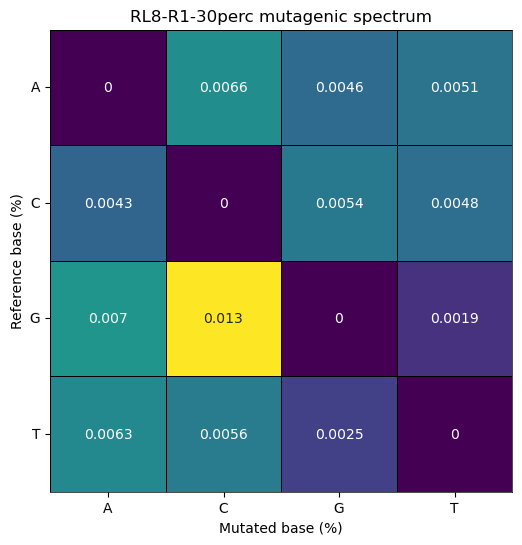

In [654]:
plot_mutation_spectrum(mut_spec_diff_mse, f"{variant}-R1-30perc", fig_folder =FigFolder)

In [657]:
percs = [0.05, 0.01] + [x * 0.1 for x in range(1, 11)]
mean_diffs_dict = {}

for  perc in percs: 
    _, mean_diffs= calc_mut_spectrum_vs_read_depth(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=False, use_forward_read=True, prop = perc, n_perms = 50)
    mean_diffs_dict[round(perc, 2)] = mean_diffs


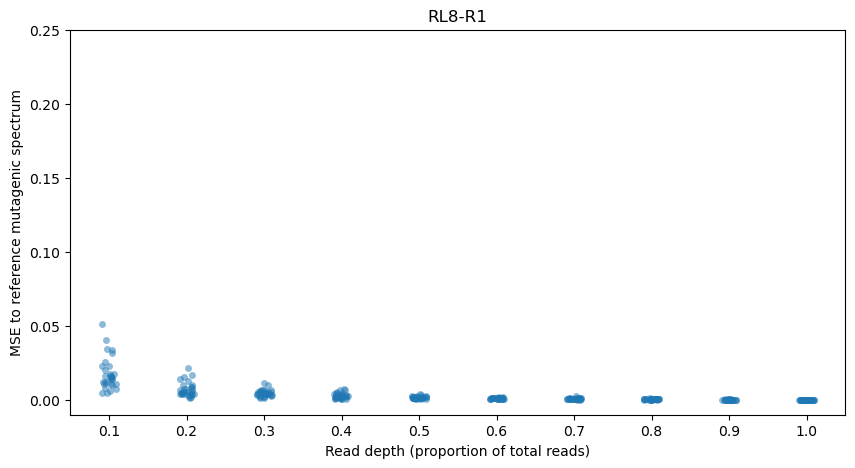

In [656]:
plt.figure(figsize=(10,5))
sns.stripplot(data=mean_diffs_dict,  alpha=0.5, color="tab:blue")
plt.ylim(-0.01, 0.25)
plt.xlim(1.5)
plt.xlabel("Read depth (proportion of total reads)")
plt.ylabel("MSE to reference mutagenic spectrum")
plt.title(name)
plt.savefig(f"{FigFolder}/{name}_mutation_rate_vs_read_depth_from10perc.pdf")
plt.show()

In [241]:
## how many A, C, G, T are in the reference sequence
for nt in set(LOV_gene): 
    print(nt, LOV_gene[-20:].count(nt))


T 3
C 4
G 6
A 7


In [ ]:
a_seq, b_seq = read_sequences("DP6")
mut_spec_codons, mut_spectrum_codons_perc =  mut_spectrum_codons(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read = False, use_forward_read = True, codon_list = codons)
mut_spectrum_codons_perc_df = pd.DataFrame.from_dict(mut_spectrum_codons_perc, orient='index')
np.fill_diagonal(mut_spectrum_codons_perc_df.values, np.nan)

total reads 59259
{'ATA': {'ATA': 0, 'ATC': 0, 'ATT': 0, 'ATG': 0, 'ACA': 0, 'ACC': 0, 'ACG': 0, 'ACT': 0, 'AAC': 0, 'AAT': 0, 'AAA': 0, 'AAG': 0, 'AGC': 0, 'AGT': 0, 'AGA': 0, 'AGG': 0, 'CTA': 0, 'CTC': 0, 'CTG': 0, 'CTT': 0, 'CCA': 0, 'CCC': 0, 'CCG': 0, 'CCT': 0, 'CAC': 0, 'CAT': 0, 'CAA': 0, 'CAG': 0, 'CGA': 0, 'CGC': 0, 'CGG': 0, 'CGT': 0, 'GTA': 0, 'GTC': 0, 'GTG': 0, 'GTT': 0, 'GCA': 0, 'GCC': 0, 'GCG': 0, 'GCT': 0, 'GAC': 0, 'GAT': 0, 'GAA': 0, 'GAG': 0, 'GGA': 0, 'GGC': 0, 'GGG': 0, 'GGT': 0, 'TCA': 0, 'TCC': 0, 'TCG': 0, 'TCT': 0, 'TTC': 0, 'TTT': 0, 'TTA': 0, 'TTG': 0, 'TAC': 0, 'TAT': 0, 'TAA': 0, 'TAG': 0, 'TGC': 0, 'TGT': 0, 'TGA': 0, 'TGG': 0}, 'ATC': {'ATA': 0, 'ATC': 0, 'ATT': 0, 'ATG': 0, 'ACA': 0, 'ACC': 0, 'ACG': 0, 'ACT': 0, 'AAC': 0, 'AAT': 0, 'AAA': 0, 'AAG': 0, 'AGC': 0, 'AGT': 0, 'AGA': 0, 'AGG': 0, 'CTA': 0, 'CTC': 0, 'CTG': 0, 'CTT': 0, 'CCA': 0, 'CCC': 0, 'CCG': 0, 'CCT': 0, 'CAC': 0, 'CAT': 0, 'CAA': 0, 'CAG': 0, 'CGA': 0, 'CGC': 0, 'CGG': 0, 'CGT': 0, 'GTA

In [ ]:
mut_spectrum_codons_df = pd.DataFrame.from_dict(mut_spec_codons, orient='index')
mut_spectrum_codons_df.sum().sum()

np.int64(6877)

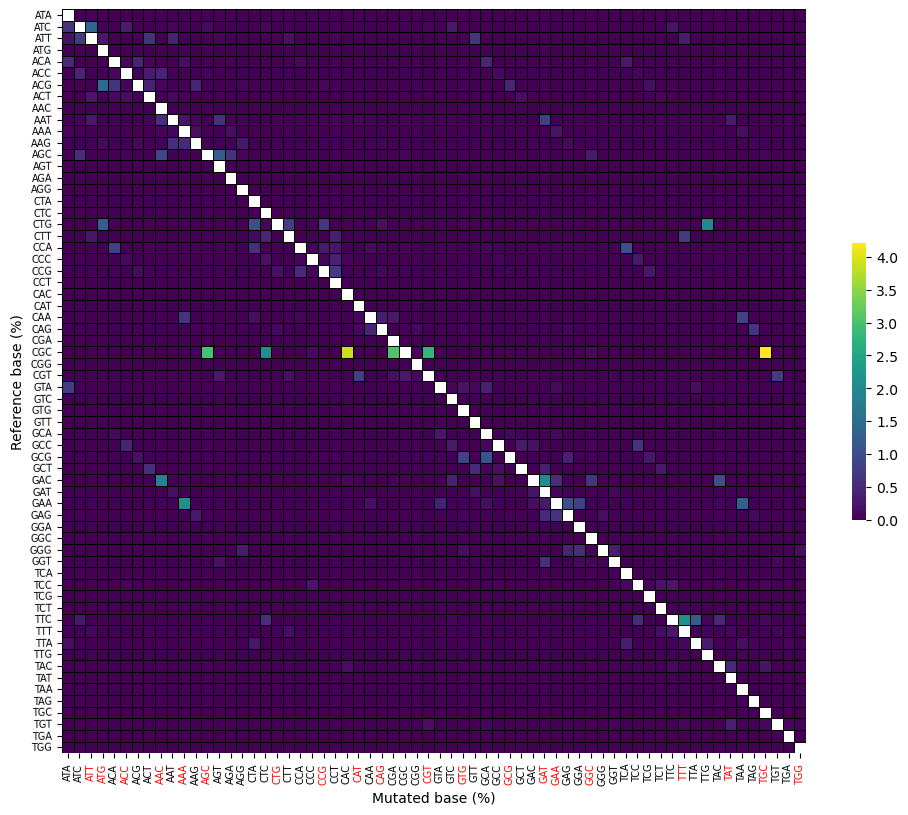

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(mut_spectrum_codons_perc_df, annot=False, linewidths=.5, ax=ax, vmin = 0, cbar = True, square = True, linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True)
plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(.5)
#ax.set_facecolor('gray')
ax.set_yticklabels(ax.get_yticklabels(), rotation=1, fontsize=7)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
for i, tick_label in enumerate(ax.get_xticklabels()):
    if tick_label.get_text() in ecoli_pref.values():
        tick_label.set_color('red')
# for i, tick_label in enumerate(ax.get_yticklabels()):
#     if tick_label.get_text() not in ecoli_pref.values():
#         tick_label.set_color('green')
plt.show()